In [1]:
import numpy as np 
import pandas as pd
import os
from sklearn.ensemble import IsolationForest
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix,ConfusionMatrixDisplay,classification_report,make_scorer, f1_score
from sklearn.utils import resample
import matplotlib.pyplot as plt
from datetime import datetime
from sklearn import model_selection
from joblib import dump, load
import mlflow.sklearn
import mlflow
from mlflow.models import infer_signature
from mlflow.tracking import MlflowClient
import sys
sys.path.append('../')
from result_display import show_result,export_anomaly
from reject_anomalies import pred_baseon_threshold,make_use_reject_anomalies
from Feature_engineer import remove_unwanted_col,feature_engineer_steps

In [ ]:
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

from sklearn.metrics import confusion_matrix
import seaborn as sns


import pandas as pd
from geopy.geocoders import Nominatim
from geopy.exc import GeocoderTimedOut

# Assuming df is your DataFrame with 'lat_customer' and 'long_customer' columns

# Initialize the Nominatim geocoder
geolocator = Nominatim(user_agent="geoapiExercises")



In [8]:
transactions_df = pd.read_csv("data/transactions_df.csv")
terminal_profiles_df = pd.read_csv("data/terminal_profiles_table.csv")
customer_profiles_df = pd.read_csv("data/customer_profiles_table.csv")
join_terminal = pd.merge(transactions_df, terminal_profiles_df, on='terminal_id', how='inner') #join dataset base on key value
df = pd.merge(join_terminal, customer_profiles_df, on='customer_id', how='inner')


In [9]:
df.columns.tolist()

['transaction_id',
 'post_ts',
 'customer_id',
 'bin_x',
 'terminal_id',
 'amt',
 'entry_mode',
 'fraud',
 'fraud_scenario',
 'lat_terminal',
 'log_terminal',
 'mcc',
 'mean_amount',
 'std_amount',
 'mean_nb_tx_per_day',
 'network_id',
 'bin_y',
 'lat_customer',
 'log_customer',
 'available_terminals',
 'nb_terminals']

In [22]:
def is_weekend(transaction_datetime):
    weekday = transaction_datetime.weekday()
    return int(weekday>=5)
def is_night(transaction_datetime):
    tx_hour = transaction_datetime.hour
    # Binary value: 1 if hour less than 6, and 0 otherwise
    return int(tx_hour<=6)

In [18]:
df['post_ts'] = pd.to_datetime(df['post_ts'])

In [19]:
df['is_weekend'] = df['post_ts'].apply(is_weekend)

In [21]:
df['is_night'] = df['post_ts'].apply(is_night)

In [33]:
!pip install geopy

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 125.4/125.4 kB 3.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 40.3/40.3 kB 3.1 MB/s eta 0:00:00


In [38]:
import pandas as pd
import reverse_geocode

# Prepare coordinates for customers and terminals
customer_coordinates = list(zip(df['lat_customer'], df['log_customer']))  # Assuming longitude column name typo is corrected
terminal_coordinates = list(zip(df['lat_terminal'], df['log_terminal']))

# Perform reverse geocoding in batches
customer_countries = reverse_geocode.search(customer_coordinates)
terminal_countries = reverse_geocode.search(terminal_coordinates)

# Extract country names and assign them to new columns
df['country_customer'] = [location['country'] for location in customer_countries]
df['country_terminal'] = [location['country'] for location in terminal_countries]

In [52]:
df['is_country_customer_terminal'] = df['country_customer'] == df['country_terminal']
df.drop(['country_customer', 'country_terminal'], axis=1, inplace=True)

KeyError: 'country_customer'

['transaction_id',
 'post_ts',
 'customer_id',
 'bin_x',
 'terminal_id',
 'amt',
 'entry_mode',
 'fraud',
 'fraud_scenario',
 'lat_terminal',
 'log_terminal',
 'mcc',
 'mean_amount',
 'std_amount',
 'mean_nb_tx_per_day',
 'network_id',
 'bin_y',
 'lat_customer',
 'log_customer',
 'available_terminals',
 'nb_terminals',
 'is_weekend',
 'is_night',
 'country_customer',
 'country_terminal',
 'is_country_customer_terminal']

In [53]:
df.sort_values(by=['customer_id', 'post_ts'], inplace=True)

# Function to calculate Haversine distance
def haversine(lat1, lon1, lat2, lon2):
    # Radius of the Earth in km
    R = 6371.0
    # Convert coordinates from degrees to radians
    lat1, lon1, lat2, lon2 = map(np.radians, [lat1, lon1, lat2, lon2])
    # Calculate the differences of the coordinates
    dlat = lat2 - lat1
    dlon = lon2 - lon1
    # Calculate the distance
    a = np.sin(dlat / 2)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon / 2)**2
    c = 2 * np.arctan2(np.sqrt(a), np.sqrt(1 - a))
    distance = R * c
    return distance

df['prev_lat'] = df.groupby('customer_id')['lat_terminal'].shift(1)
df['prev_lon'] = df.groupby('customer_id')['log_terminal'].shift(1)
df['distance_to_prev'] = haversine(df['lat_terminal'], df['log_terminal'], df['prev_lat'], df['prev_lon'])

df['is_same_region'] = df['distance_to_prev'].le(200) | df['distance_to_prev'].isna()

df.drop(['prev_lat', 'prev_lon', 'distance_to_prev'], axis=1, inplace=True)

In [54]:
train_X,train_y = feature_engineer_steps(df)

In [55]:
train_X = remove_unwanted_col(train_X)

In [56]:
# Assuming train_X is your feature matrix
scaler = StandardScaler()
X_train, X_test, y_train, y_test = train_test_split(train_X, train_y, test_size=0.05, random_state=42)
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


In [63]:
# Choose the number of clusters based on your elbow method plot
def model_train(n_clusters, X_train_scaled):
    kmeans = KMeans(n_clusters=n_clusters, init='k-means++', max_iter=300, n_init=10, random_state=42)
    kmeans.fit(X_train_scaled)
    
    distances = kmeans.transform(X_train_scaled)
    closest_cluster_distance = np.min(distances, axis=1)

    threshold = np.percentile(closest_cluster_distance, 95)

    y_pred = closest_cluster_distance > threshold
    return y_pred

In [69]:
y_pred = []
for i in range(1,10):
    y_pred.append(model_train(i, X_train_scaled))
    print(f'finished train N{i}')
print(y_pred)

finished train N1
finished train N2
finished train N3
finished train N4
finished train N5
finished train N6
finished train N7
finished train N8
finished train N9
[array([False, False, False, ..., False, False, False]), array([False, False, False, ..., False, False, False]), array([False, False, False, ..., False, False, False]), array([False, False, False, ..., False, False, False]), array([False, False, False, ..., False, False, False]), array([False, False, False, ..., False, False, False]), array([False, False, False, ..., False, False, False]), array([False, False, False, ..., False, False, False]), array([False, False, False, ..., False, False, False])]


In [70]:
# Define function to calculate accuracy
def calculate_accuracy(cm):
    TN, FP, FN, TP = cm.ravel()
    accuracy = (TP + TN) / (TP + FP + FN + TN)
    return accuracy * 100

In [71]:
# Define function to plot confusion matrix
def plot_confusion_matrix(y_train, anomalies, ax, accuracies):
    cm = confusion_matrix(y_train, anomalies)
    accuracy = calculate_accuracy(cm)
    accuracies.append(accuracy)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Normal', 'Anomaly'], yticklabels=['Normal', 'Anomaly'], ax=ax)
    ax.set_xlabel('Predicted')
    ax.set_ylabel('Actual')
    ax.set_title(f'Confusion Matrix (Accuracy: {accuracy:.2f}%)')


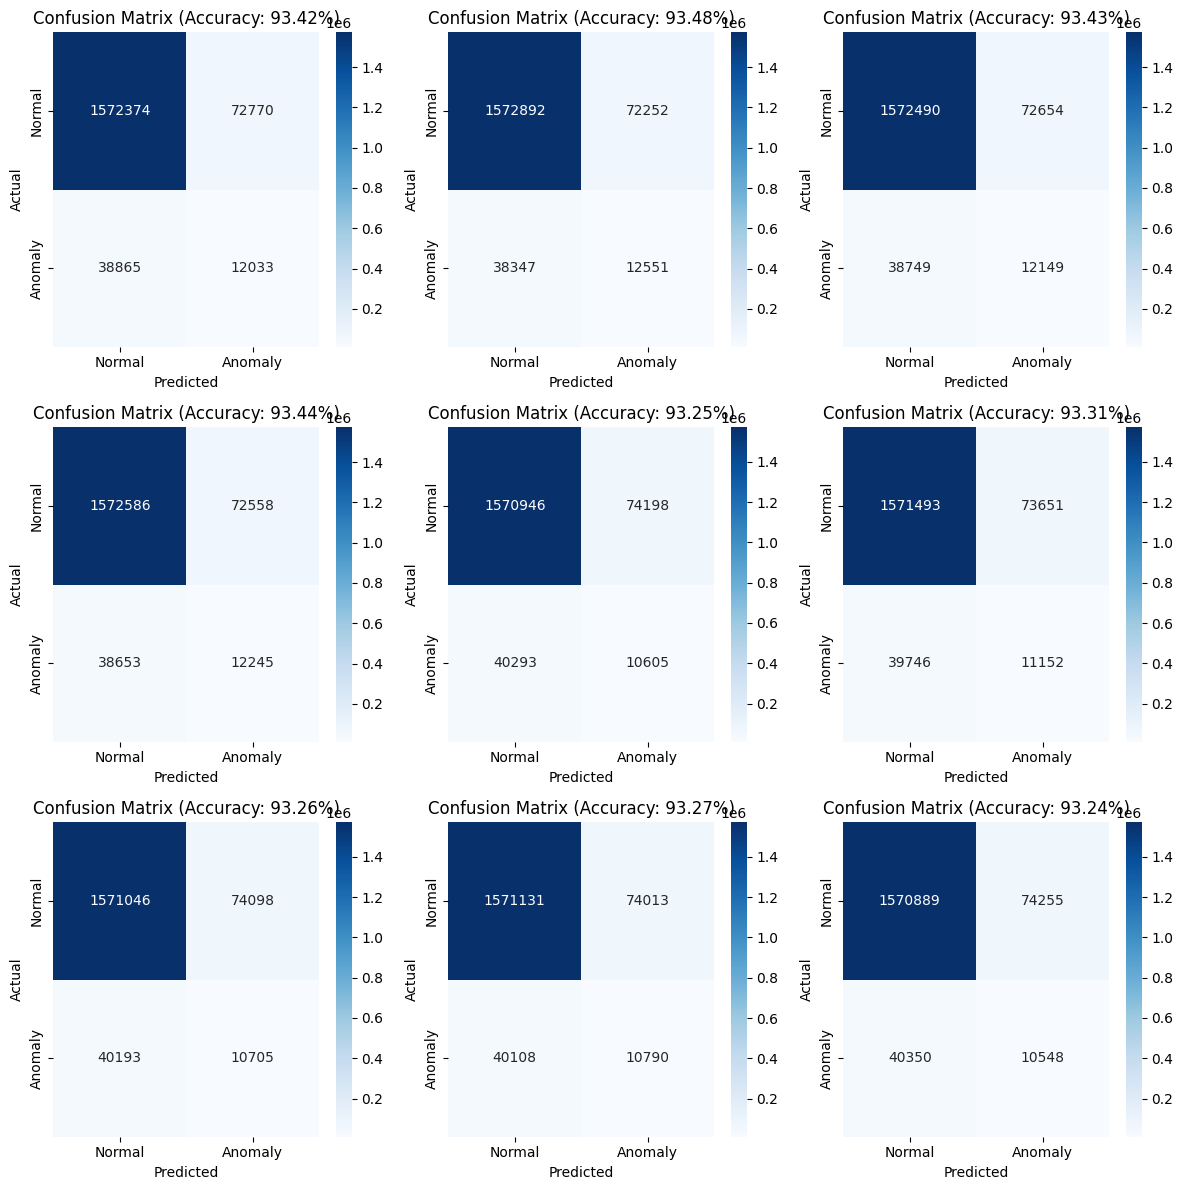

In [72]:
# Create lists to store accuracies
accuracies = []
# Create 3x3 subplot grid
fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(12, 12))

# Iterate through anomalies_full and plot subplots
for idx, pred in enumerate(y_pred):
    row = idx // 3
    col = idx % 3
    ax = axes[row, col]
    # print(len(y_train), len(pred))
    plot_confusion_matrix(y_train, pred, ax, accuracies)
plt.tight_layout()
plt.show()

In [73]:
n_clusters_optimal = 2

kmeans_optimal = KMeans(n_clusters=n_clusters_optimal, init='k-means++', max_iter=300, n_init=10, random_state=0)
kmeans_optimal.fit(X_train_scaled)
dump(kmeans_optimal, 'saved_model/best_model.joblib')

['saved_model/best_model.joblib']